In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

/work/mmarcheg/miniconda3/envs/pocket-coffea/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=400000).events()

In [3]:
events.Jet.rawFactor

<Array [[0.0635, 0.04, ... -0.00543, -0.664]] type='400000 * var * float32[param...'>

In [4]:
SF = ak.flatten(1 - events.Jet.rawFactor)
SF

<Array [0.937, 0.96, 0.958, ... 1.01, 1.66] type='4343693 * float32'>

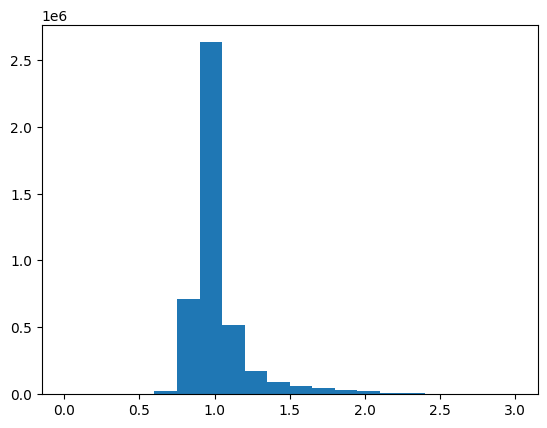

In [5]:
plt.hist(SF, bins=20, range=(0,3));

In [6]:
pt_raw = (1 - events.Jet['rawFactor']) * events.Jet['pt']

In [7]:
ratio = ak.flatten(events.Jet.pt/pt_raw)
ratio

<Array [1.07, 1.04, 1.04, ... 0.995, 0.601] type='4343693 * float32'>

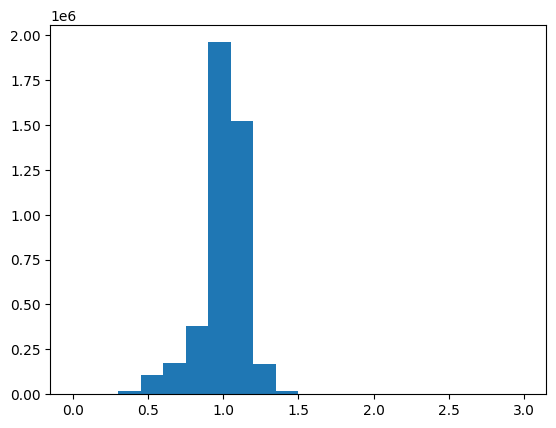

In [8]:
plt.hist(ratio, bins=20, range=(0,3));

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 2.050000e+02,
        2.136400e+04, 7.107010e+05, 2.630348e+06, 5.204000e+05,
        1.720750e+05, 9.079700e+04, 6.480300e+04, 4.666500e+04,
        3.338600e+04, 2.284300e+04, 1.320600e+04, 8.632000e+03,
        4.469000e+03, 1.948000e+03, 1.068000e+03, 5.150000e+02]),
 array([0.        , 0.15000001, 0.30000001, 0.44999999, 0.60000002,
        0.75      , 0.89999998, 1.04999995, 1.20000005, 1.35000002,
        1.5       , 1.64999998, 1.79999995, 1.95000005, 2.0999999 ,
        2.25      , 2.4000001 , 2.54999995, 2.70000005, 2.8499999 ,
        3.        ]),
 <BarContainer object of 20 artists>)

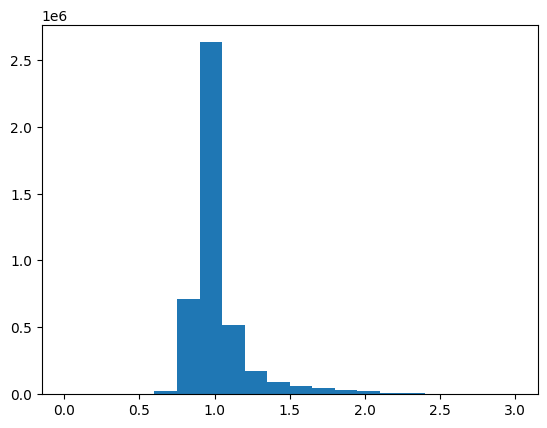

In [9]:
plt.hist(1/ratio, bins=20, range=(0,3))

# Testing the coffea implementation

In [10]:
import gzip

import cloudpickle

In [11]:
path = "../pocket_coffea/parameters/jec/jets_evaluator.pkl.gz"

In [12]:
with gzip.open(path) as fin:
        jmestuff = cloudpickle.load(fin)

In [16]:
jmestuff['fatjet_factory']['2018']

In [17]:
def add_jec_variables(jets, event_rho):
    jets["pt_raw"] = (1 - jets.rawFactor)*jets.pt
    jets["mass_raw"] = (1 - jets.rawFactor)*jets.mass
    jets["pt_gen"] = ak.values_astype(ak.fill_none(jets.matched_gen.pt, 0), np.float32)
    jets["event_rho"] = ak.broadcast_arrays(event_rho, jets.pt)[0]
    return jets


In [18]:
import cachetools
jec_cache = cachetools.Cache(np.inf)

In [19]:
%%time
#j = jmestuff["jet_factory"]["2018"].build(add_jec_variables(events.Jet,events.fixedGridRhoFastjetAll), jec_cache)
j = jmestuff["fatjet_factory"]["2018"].build(add_jec_variables(events.FatJet,events.fixedGridRhoFastjetAll), jec_cache)

CPU times: user 2.3 s, sys: 165 ms, total: 2.46 s
Wall time: 7.43 s


In [20]:
[f for f in j.fields if "JES" in f]

['JES_AbsoluteStat',
 'JES_AbsoluteScale',
 'JES_AbsoluteSample',
 'JES_AbsoluteFlavMap',
 'JES_AbsoluteMPFBias',
 'JES_Fragmentation',
 'JES_SinglePionECAL',
 'JES_SinglePionHCAL',
 'JES_FlavorQCD',
 'JES_TimePtEta',
 'JES_RelativeJEREC1',
 'JES_RelativeJEREC2',
 'JES_RelativeJERHF',
 'JES_RelativePtBB',
 'JES_RelativePtEC1',
 'JES_RelativePtEC2',
 'JES_RelativePtHF',
 'JES_RelativeBal',
 'JES_RelativeSample',
 'JES_RelativeFSR',
 'JES_RelativeStatFSR',
 'JES_RelativeStatEC',
 'JES_RelativeStatHF',
 'JES_PileUpDataMC',
 'JES_PileUpPtRef',
 'JES_PileUpPtBB',
 'JES_PileUpPtEC1',
 'JES_PileUpPtEC2',
 'JES_PileUpPtHF',
 'JES_PileUpMuZero',
 'JES_PileUpEnvelope',
 'JES_SubTotalPileUp',
 'JES_SubTotalRelative',
 'JES_SubTotalPt',
 'JES_SubTotalScale',
 'JES_SubTotalAbsolute',
 'JES_SubTotalMC',
 'JES_Total',
 'JES_TotalNoFlavor',
 'JES_TotalNoTime',
 'JES_TotalNoFlavorNoTime',
 'JES_FlavorZJet',
 'JES_FlavorPhotonJet',
 'JES_FlavorPureGluon',
 'JES_FlavorPureQuark',
 'JES_FlavorPureCharm',


In [86]:
%%time
j.JES_HF_2018.up.pt

CPU times: user 3.81 ms, sys: 0 ns, total: 3.81 ms
Wall time: 3.39 ms


<Array [[178, 94, 75.9, ... 22.2, 25, 23.4]] type='400000 * var * float32'>

Text(0.5, 0, 'Jets pt')

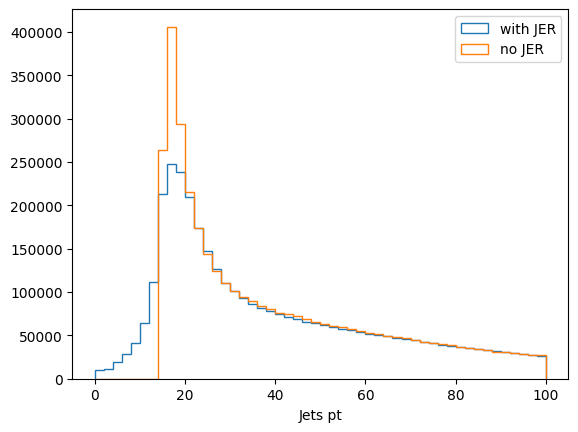

In [93]:
plt.hist(ak.flatten(j.pt), bins=50, range=(0,100), histtype="step", label="with JER")
plt.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step",label="no JER")
plt.legend()
plt.xlabel("Jets pt")

(array([ 11039.,  13818.,  24235.,  36152.,  49853.,  78287., 149886.,
        247230., 255970., 229251., 192016., 160199., 136065., 118373.,
        106003.,  97323.,  90028.,  84248.,  80024.,  76970.,  73153.,
         70420.,  68014.,  65194.,  62913.,  61074.,  58959.,  57185.,
         55294.,  53046.,  51664.,  49842.,  47987.,  46388.,  45223.,
         43309.,  41689.,  40407.,  38796.,  37766.,  36062.,  34896.,
         34008.,  32544.,  31003.,  29933.,  29405.,  27789.,  26699.,
         25998.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7f97285e5190>])

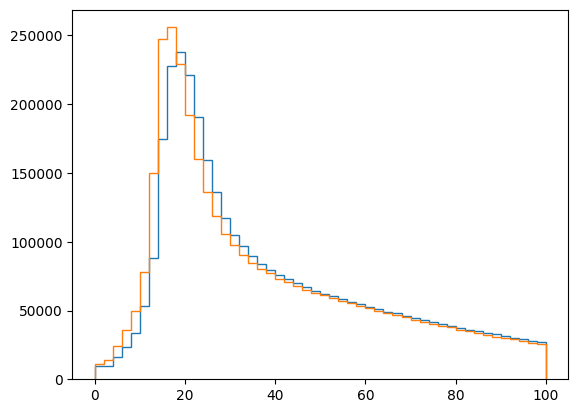

In [95]:
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(j.JES_jes.down.pt), bins=50, range=(0,100), histtype="step")

(array([  9419.,   9520.,  15891.,  23578.,  33505.,  53124.,  88488.,
        175039., 227541., 237822., 221191., 190696., 159588., 135980.,
        117390., 104570.,  96696.,  89866.,  83739.,  79227.,  75878.,
         72617.,  69942.,  66763.,  64502.,  62184.,  60499.,  58119.,
         56514.,  54766.,  52686.,  51045.,  49051.,  47998.,  46238.,
         44772.,  43138.,  41647.,  40153.,  38745.,  37402.,  36196.,
         34923.,  33923.,  32695.,  31263.,  30054.,  29398.,  27819.,
         27141.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7fc48f640a60>])

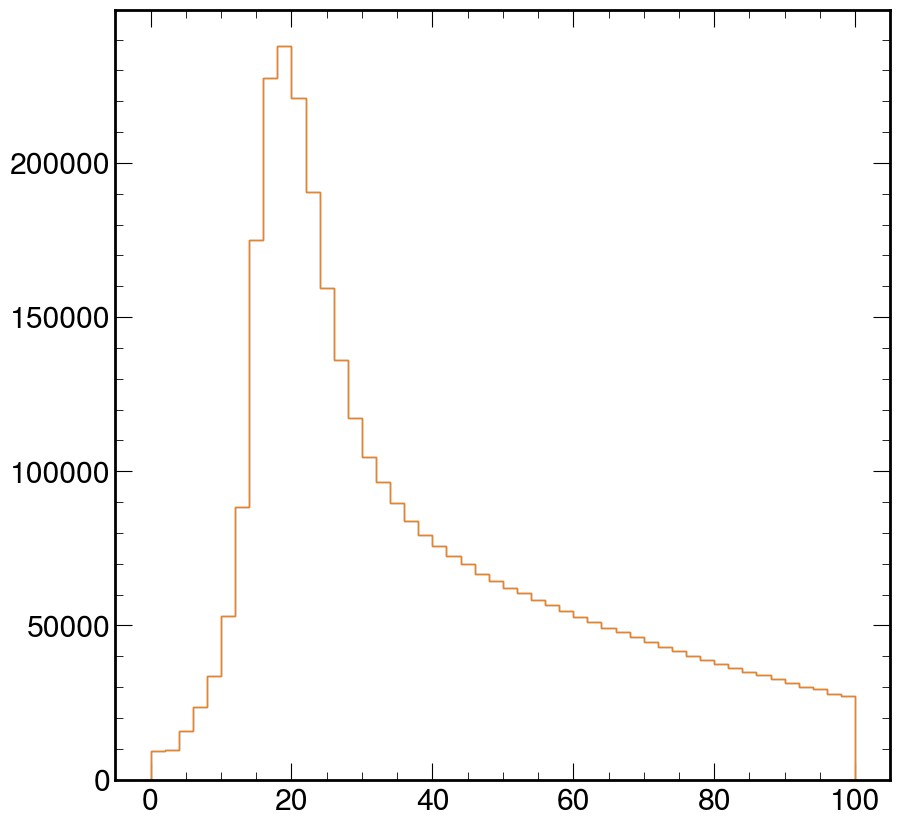

In [29]:
plt.hist(ak.flatten(j.JES_Total.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")

In [96]:
events["Jet"] = j.JES_jes.up

(array([  9419.,   9520.,  15891.,  23578.,  33505.,  53124.,  88488.,
        175039., 227541., 237822., 221191., 190696., 159588., 135980.,
        117390., 104570.,  96696.,  89866.,  83739.,  79227.,  75878.,
         72617.,  69942.,  66763.,  64502.,  62184.,  60499.,  58119.,
         56514.,  54766.,  52686.,  51045.,  49051.,  47998.,  46238.,
         44772.,  43138.,  41647.,  40153.,  38745.,  37402.,  36196.,
         34923.,  33923.,  32695.,  31263.,  30054.,  29398.,  27819.,
         27141.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7f97283cc310>])

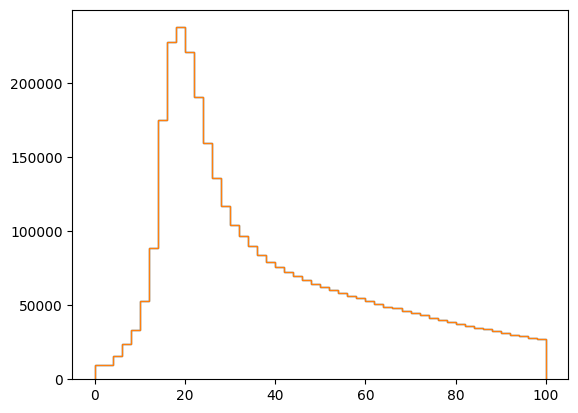

In [100]:
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step")

# PocketCoffea test

In [3]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.util import load
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep

from coffea.util import load
from coffea.hist import plot
import numpy as np
import pandas as pd

from pprint import pprint 
hep.style.use(hep.style.ROOT)

In [9]:
from coffea.util import load
df = load("../output/test_shape_variations_v23/output.coffea")

In [10]:
H = df["variables"]["JetGood_pt_1"]["ttHTobb"]
H

Hist(
  StrCategory(['baseline'], name='cat', label='Category'),
  StrCategory(['nominal', 'JES_jesDown', 'JES_jesUp', 'pileupDown', 'pileupUp', 'sf_btag_cferr1Down', 'sf_btag_cferr1Up', 'sf_btag_cferr2Down', 'sf_btag_cferr2Up', 'sf_btag_hfDown', 'sf_btag_hfUp', 'sf_btag_hfstats1Down', 'sf_btag_hfstats1Up', 'sf_btag_hfstats2Down', 'sf_btag_hfstats2Up', 'sf_btag_lfDown', 'sf_btag_lfUp', 'sf_btag_lfstats1Down', 'sf_btag_lfstats1Up', 'sf_btag_lfstats2Down', 'sf_btag_lfstats2Up', 'sf_ele_idDown', 'sf_ele_idUp', 'sf_ele_recoDown', 'sf_ele_recoUp', 'sf_jet_puIdDown', 'sf_jet_puIdUp', 'sf_mu_idDown', 'sf_mu_idUp', 'sf_mu_isoDown', 'sf_mu_isoUp'], name='variation', label='Variation'),
  StrCategory(['2018'], name='year', label='Year'),
  Regular(150, 0, 1500, name='JetGood.pt', label='$p_{T}^{j}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=47278.4, variance=1139.12) (WeightedSum(value=47279.9, variance=1139.15) with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fc499612fd0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

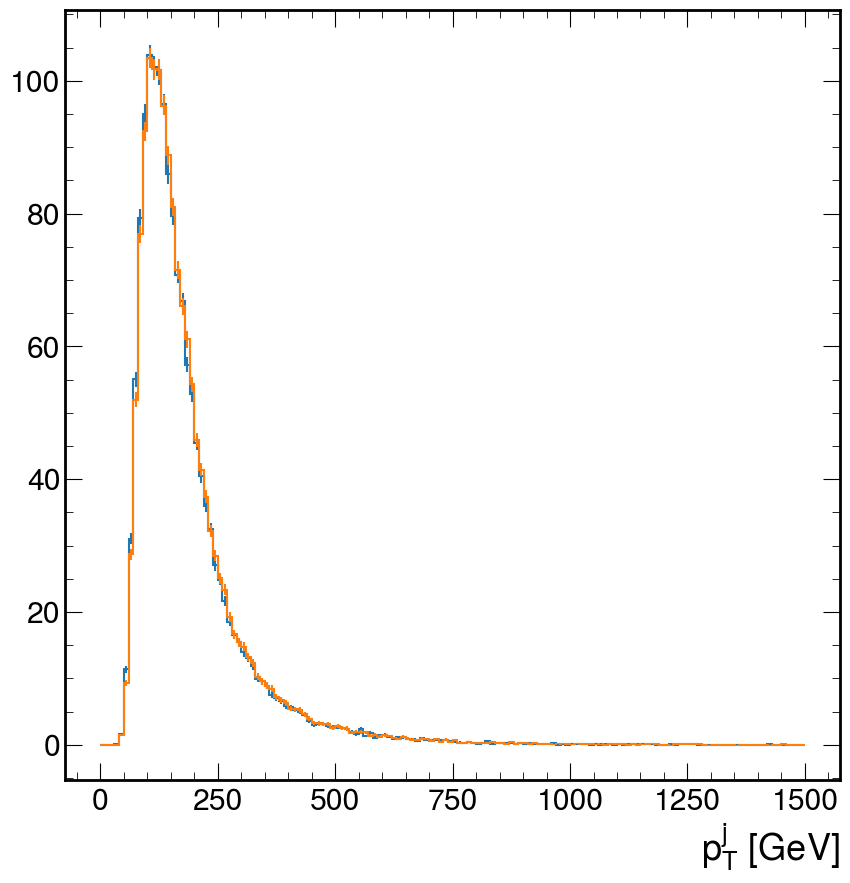

In [12]:
hep.histplot(H[{"variation":"nominal", "cat":"baseline", "year":"2018"}])
hep.histplot(H[{"variation":"JES_jesUp", "cat":"baseline", "year":"2018"}])

In [ ]:
shapes = [
    ('ttHTobb', 'baseline', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_muon_pt", shapes, ylog=True)